In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder

# Task 1: Feature Selection

## Load the dataset.

In [71]:
titanic = pd.read_csv('titanic.csv')

In [72]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [73]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [74]:
titanic['Age'].mean()

29.69911764705882

In [75]:
# Imputing missing values in age column with mean
titanic['Age'].fillna(titanic['Age'].mean(), inplace = True)
titanic['Age'] = titanic['Age'].astype(int)

In [76]:
# Imputing missing values in Embarked column with mode
titanic['Embarked'].fillna(titanic['Embarked'].mode().iloc[0], inplace = True)

In [77]:
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

## Analyze the correlation between features and the target variable.

In [78]:
correlation_matrix = titanic.select_dtypes(include=['int', 'float']).corr()

In [79]:
correlation_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.033741,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.067809,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.335071,0.083081,0.018443,-0.549500
Age,0.033741,-0.067809,-0.335071,1.000000,-0.232743,-0.176744,0.093856
SibSp,-0.057527,-0.035322,0.083081,-0.232743,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.176744,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.093856,0.159651,0.216225,1.000000


Text(0.5, 1.0, 'Correlation matrix')

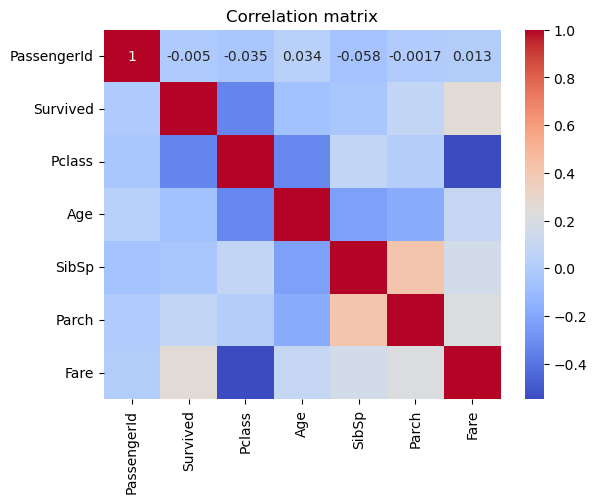

In [80]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')

In [81]:
correlation_with_target = correlation_matrix['Survived'].sort_values(ascending=False)
correlation_with_target

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.067809
Pclass        -0.338481
Name: Survived, dtype: float64

Text(0.5, 1.0, 'correlation with the target variable Survived')

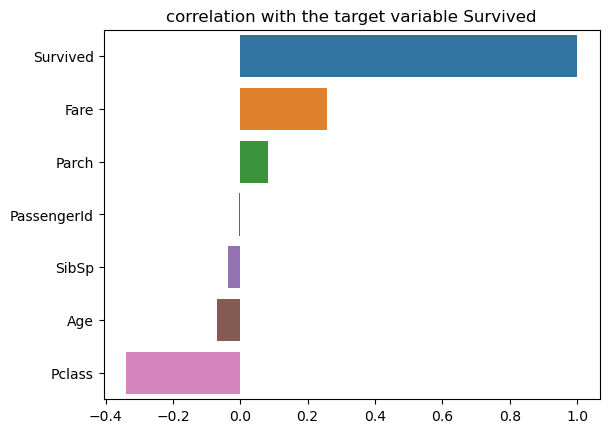

In [82]:
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)
plt.title('correlation with the target variable Survived')

## Use methods like mutual information or chi-squared test to select important features.

#### Mutual Information

In [83]:
# Encode categorical features: Sex and Embarked
label_encoders = {}
for column in titanic.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    titanic[column] = label_encoders[column].fit_transform(titanic[column].astype(str))

In [84]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22,1,0,7.2500,2
1,2,1,1,0,38,1,0,71.2833,0
2,3,1,3,0,26,0,0,7.9250,2
3,4,1,1,0,35,1,0,53.1000,2
4,5,0,3,1,35,0,0,8.0500,2


In [85]:
X = titanic.drop(columns=['Survived'])
y = titanic['Survived']
mutual_info = mutual_info_classif(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
mutual_info_series

Sex            0.159380
Fare           0.131525
Pclass         0.049781
Age            0.026406
PassengerId    0.020153
Parch          0.017287
Embarked       0.006030
SibSp          0.000000
dtype: float64

#### Chi-Squared Test

In [86]:
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

features_to_bin = ['Age', 'Fare']

In [87]:
for feature in features_to_bin:
    binned_feature = kbins.fit_transform(titanic[[feature]])
    titanic[f'{feature}_binned'] = binned_feature

X = titanic.drop(columns=['Survived'])
y = titanic['Survived']

In [88]:
chi2_values, p_values = chi2(X, y)

chi2_results = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_values, 'p-value': p_values})
chi2_results.sort_values(by='Chi2', ascending=False, inplace=True)

In [89]:
chi2_results

,Feature,Chi2,p-value
6,Fare,4518.319091,0.000000e+00
2,Sex,92.702447,6.077838e-22
9,Fare_binned,44.013942,3.260453e-11
1,Pclass,30.873699,2.753786e-08
3,Age,23.458444,1.276412e-06
7,Embarked,10.202525,1.402485e-03
5,Parch,10.097499,1.484707e-03
0,PassengerId,3.312934,6.873667e-02
4,SibSp,2.581865,1.080942e-01
8,Age_binned,0.515100,4.729396e-01


In [90]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_binned,Fare_binned
0,1,0,3,1,22,1,0,7.2500,2,1.0,0.0
1,2,1,1,0,38,1,0,71.2833,0,2.0,0.0
2,3,1,3,0,26,0,0,7.9250,2,1.0,0.0
3,4,1,1,0,35,1,0,53.1000,2,2.0,0.0
4,5,0,3,1,35,0,0,8.0500,2,2.0,0.0


## Document the selected features and explain why they were chosen.

`Selected Features and Reasons`:

**Sex**: This feature has a high chi-squared value and high mutual information score, indicating a strong association with survival. Women had higher survival rates, making this feature crucial for predicting survival.

**Pclass**: This feature shows high chi-squared value and mutual information score, highlighting its importance in predicting survival.

**Fare**: After binning, this feature shows significant chi-squared value and mutual information score, suggesting its relevance.

# Task 2: Feature Transformation

## Log Transformation

array([[<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Fare_log'}>]], dtype=object)

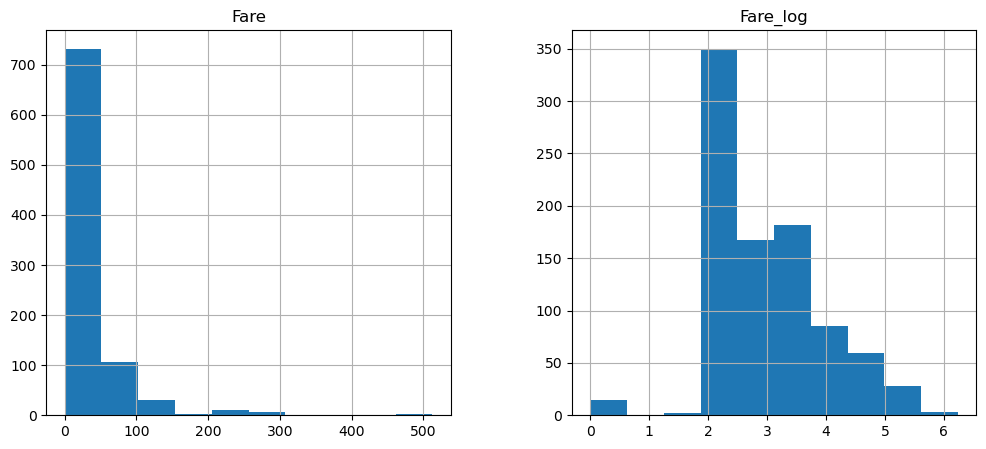

In [91]:
titanic['Fare_log'] = np.log1p(titanic['Fare']) 

titanic[['Fare', 'Fare_log']].hist(figsize=(12, 5))

## Normalization

In [92]:
normalizer = MinMaxScaler()
titanic[['Age_normalized', 'Fare_log_normalized']] = normalizer.fit_transform(titanic[['Age', 'Fare_log']])

## Standardization

In [93]:
scaler = StandardScaler()
titanic[['Age_scaled', 'Fare_log_scaled']] = scaler.fit_transform(titanic[['Age', 'Fare_log']])

In [94]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_binned,Fare_binned,Fare_log,Age_normalized,Fare_log_normalized,Age_scaled,Fare_log_scaled
0,1,0,3,1,22,1,0,7.2500,2,1.0,0.0,2.110213,0.2750,0.338125,-0.580044,-0.879741
1,2,1,1,0,38,1,0,71.2833,0,2.0,0.0,4.280593,0.4750,0.685892,0.650112,1.361220
2,3,1,3,0,26,0,0,7.9250,2,1.0,0.0,2.188856,0.3250,0.350727,-0.272505,-0.798540
3,4,1,1,0,35,1,0,53.1000,2,2.0,0.0,3.990834,0.4375,0.639463,0.419458,1.062038
4,5,0,3,1,35,0,0,8.0500,2,2.0,0.0,2.202765,0.4375,0.352955,0.419458,-0.784179


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Age_normalized'}>],
       [<Axes: title={'center': 'Age_scaled'}>, <Axes: >]], dtype=object)

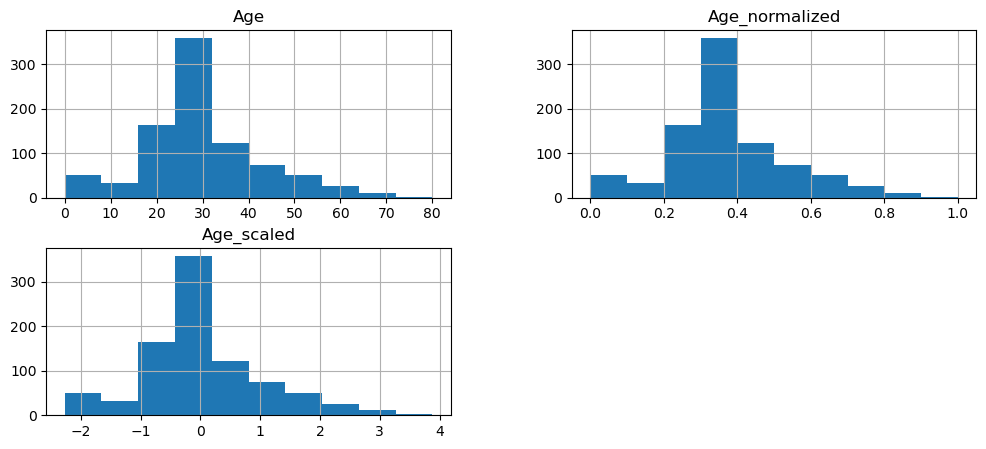

In [95]:
titanic[['Age', 'Age_normalized', 'Age_scaled']].hist(figsize=(12, 5))

array([[<Axes: title={'center': 'Fare_log'}>,
        <Axes: title={'center': 'Fare_log_normalized'}>],
       [<Axes: title={'center': 'Fare_log_scaled'}>, <Axes: >]],
      dtype=object)

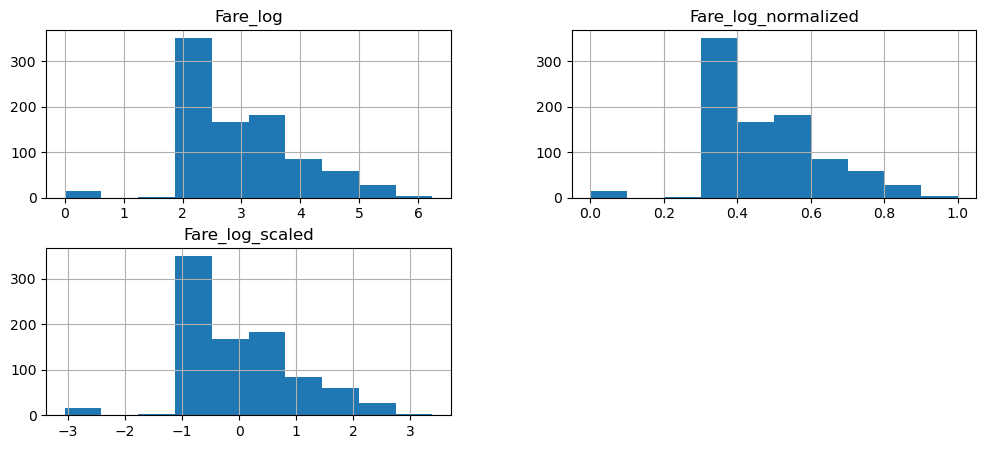

In [96]:
titanic[['Fare_log', 'Fare_log_normalized', 'Fare_log_scaled']].hist(figsize=(12, 5))

# Task 3: Feature Creation

## Interaction Terms

In [97]:
titanic['Pclass_Sex'] = titanic['Pclass'] * titanic['Sex']

In [98]:
titanic[['Pclass', 'Sex', 'Pclass_Sex']].head()

,Pclass,Sex,Pclass_Sex
0,3,1,3
1,1,0,0
2,3,0,0
3,1,0,0
4,3,1,3


## Binning

In [99]:
age_bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
titanic['Age_group'] = pd.cut(titanic['Age'], bins=age_bins, labels=age_labels)

In [118]:
titanic[['Age', 'Age_group']].head(10)

,Age,Age_group
0,22,Young Adult
1,38,Adult
2,26,Young Adult
3,35,Young Adult
4,35,Young Adult
5,29,Young Adult
6,54,Adult
7,2,Child
8,27,Young Adult
9,14,Teenager


## Family Size
Create a new feature for family size by combining **`SibSp`** (siblings/spouses) and **`Parch`** (parents/children).

In [101]:
titanic['Family_size'] = titanic['SibSp'] + titanic['Parch'] + 1  # Adding 1 for the passenger themselves

In [119]:
titanic[['SibSp', 'Parch', 'Family_size']].head(10)

,SibSp,Parch,Family_size
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


# Task 4: Polynomial Features

## Load the Dataset

In [103]:
from sklearn.datasets import fetch_california_housing

In [104]:
housing = fetch_california_housing()
housing_data = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_data['MedHouseVal'] = housing.target  

In [105]:
housing_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Generate Polynomial Features

In [106]:
# Selecting a subset of features for polynomial feature generation
features = ['MedInc', 'AveOccup']
X = housing_data[features]

In [107]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features))

In [108]:
X_poly_df.head()

,MedInc,AveOccup,MedInc^2,MedInc AveOccup,AveOccup^2
0,8.3252,2.555556,69.308955,21.275511,6.530864
1,8.3014,2.109842,68.913242,17.514641,4.451433
2,7.2574,2.802260,52.669855,20.337121,7.852660
3,5.6431,2.547945,31.844578,14.378310,6.492025
4,3.8462,2.181467,14.793254,8.390359,4.758799


# Task 5: Handling Categorical Features

In [109]:
titanic.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_binned,Fare_binned,Fare_log,Age_normalized,Fare_log_normalized,Age_scaled,Fare_log_scaled,Pclass_Sex,Age_group,Family_size
0,1,0,3,1,22,1,0,7.2500,2,1.0,0.0,2.110213,0.2750,0.338125,-0.580044,-0.879741,3,Young Adult,2
1,2,1,1,0,38,1,0,71.2833,0,2.0,0.0,4.280593,0.4750,0.685892,0.650112,1.361220,0,Adult,2
2,3,1,3,0,26,0,0,7.9250,2,1.0,0.0,2.188856,0.3250,0.350727,-0.272505,-0.798540,0,Young Adult,1
3,4,1,1,0,35,1,0,53.1000,2,2.0,0.0,3.990834,0.4375,0.639463,0.419458,1.062038,0,Young Adult,2
4,5,0,3,1,35,0,0,8.0500,2,2.0,0.0,2.202765,0.4375,0.352955,0.419458,-0.784179,3,Young Adult,1


## One-Hot Encoding

In [110]:
categorical_features = ['Sex', 'Embarked', 'Pclass', 'Age_group']

encoder = OneHotEncoder(sparse_output=False, drop='first')  
encoded_features = encoder.fit_transform(titanic[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

In [111]:
encoded_features_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

titanic_data_encoded = pd.concat([titanic, encoded_features_df], axis=1)
titanic_data_encoded.drop(columns=categorical_features, inplace=True)

In [112]:
titanic_data_encoded.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Age_binned,Fare_binned,Fare_log,Age_normalized,...,Sex_1,Embarked_1,Embarked_2,Pclass_2,Pclass_3,Age_group_Child,Age_group_Senior,Age_group_Teenager,Age_group_Young Adult,Age_group_nan
0,1,0,22,1,0,7.2500,1.0,0.0,2.110213,0.2750,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2,1,38,1,0,71.2833,2.0,0.0,4.280593,0.4750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,26,0,0,7.9250,1.0,0.0,2.188856,0.3250,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,1,35,1,0,53.1000,2.0,0.0,3.990834,0.4375,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0,35,0,0,8.0500,2.0,0.0,2.202765,0.4375,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Label Encoding

In [113]:
label_encoder = LabelEncoder()
titanic['Age_group_label_encoded'] = label_encoder.fit_transform(titanic['Age_group'])

In [114]:
titanic[['Age_group', 'Age_group_label_encoded']].head(10)

,Age_group,Age_group_label_encoded
0,Young Adult,4
1,Adult,0
2,Young Adult,4
3,Young Adult,4
4,Young Adult,4
5,Young Adult,4
6,Adult,0
7,Child,1
8,Young Adult,4
9,Teenager,3


## Target Encoding

In [115]:
target_encoder = ce.TargetEncoder(cols=['Age_group'])
titanic['Age_group_target_encoded'] = target_encoder.fit_transform(titanic['Age_group'], titanic['Survived'])

In [116]:
titanic[['Age_group', 'Age_group_target_encoded']].head()

,Age_group,Age_group_target_encoded
0,Young Adult,0.353271
1,Adult,0.400000
2,Young Adult,0.353271
3,Young Adult,0.353271
4,Young Adult,0.353271
